
# Sensei — Unit enonomy

All values in **USD**  


In [36]:
import math
import numpy as np
import pandas as pd
from IPython.display import display

# ---------- INPUTS (edit here only) ----------
price_usd                = 10.00     # monthly subscription price
stripe_fee_pct           = 0.02      # Stripe fee (fraction), e.g. 0.02 = 2%
server_cost_per_user     = 0.06      # $/active user/month
tokens_cost_per_user     = 20.00     # $/active user/month (current)
cpc_usd                  = 0.05     # Meta ads CPC
cr_points                = [0.03, 0.05, 0.07, 0.10]   # Click→Signup conversion rates to compare
lifetime_months          = 6         # average months retained
target_payback_months    = 3         # target payback threshold

# ---------- SAFETY ----------
if not (0 < stripe_fee_pct < 1): raise ValueError("stripe_fee_pct must be in (0,1).")
for cr in cr_points:
    if not (0 < cr <= 1): raise ValueError("All values in cr_points must be in (0,1].")
if price_usd <= 0 or cpc_usd <= 0 or server_cost_per_user < 0 or tokens_cost_per_user < 0:
    raise ValueError("Check numeric inputs (must be non-negative; price/cpc > 0).")

# ---------- CORE HELPERS ----------
def monthly_margin(tokens_cost):
    stripe_fee = price_usd * stripe_fee_pct
    return price_usd - (stripe_fee + server_cost_per_user + tokens_cost)

def cac_from(cpc, cr):
    return cpc / cr

def ltv_contribution(margin, lifetime_m):
    return max(0.0, margin) * lifetime_m

def token_cap_for_payback(cac, target_payback_m):
    stripe_fee = price_usd * stripe_fee_pct
    return price_usd - stripe_fee - server_cost_per_user - (cac / target_payback_m)

# ---------- DERIVED CONSTANTS ----------
stripe_usd = price_usd * stripe_fee_pct
opex_usd   = stripe_usd + server_cost_per_user + tokens_cost_per_user
margin_usd = monthly_margin(tokens_cost_per_user)

# ---------- TABLE 1: Inputs (resolved) ----------
inputs_tbl = pd.DataFrame({
    "Input": ["Price (monthly)", "Stripe %", "Stripe (USD)", "Server (USD)", "Tokens (USD)",
              "CPC", "Lifetime (months)", "Target payback (months)"],
    "Value": [price_usd, stripe_fee_pct, round(stripe_usd,2), server_cost_per_user, tokens_cost_per_user,
              cpc_usd, lifetime_months, target_payback_months]
})
print("=== Inputs ===")
display(inputs_tbl)

# ---------- TABLE 2: CAC by CR ----------
cac_rows = [{"CR": f"{cr*100:.0f}%", "CAC (USD/signup)": round(cac_from(cpc_usd, cr), 2)} for cr in cr_points]
cac_tbl = pd.DataFrame(cac_rows)
print("\n=== CAC Sensitivity (by Click→Signup CR) ===")
display(cac_tbl)

# ---------- TABLE 3: Unit Economics per CR (using current tokens) ----------
ue_rows = []
for cr in cr_points:
    cac = cac_from(cpc_usd, cr)
    pb  = math.inf if margin_usd <= 0 else cac / margin_usd
    ltv = ltv_contribution(margin_usd, lifetime_months)
    ue_rows.append({
        "CR": f"{cr*100:.0f}%",
        "Monthly margin (USD)": round(margin_usd, 2),
        "CAC (USD)": round(cac, 2),
        "Payback (months)": (np.inf if math.isinf(pb) else round(pb, 2)),
        "LTV (contrib, USD)": round(ltv, 2),
        "LTV/CAC": (None if ltv <= 0 else round(ltv / cac, 2))
    })
ue_tbl = pd.DataFrame(ue_rows)
print("\n=== Unit Economics (current tokens) ===")
display(ue_tbl)

# ---------- TABLE 4: Max tokens to hit target payback (by CR) ----------
cap_rows = []
for cr in cr_points:
    cap = token_cap_for_payback(cac_from(cpc_usd, cr), target_payback_months)
    cap_rows.append({"CR": f"{cr*100:.0f}%", f"Max tokens for payback ≤ {target_payback_months} mo (USD/mo)": round(cap, 2)})
cap_tbl = pd.DataFrame(cap_rows)
print(f"\n=== Token Cost Cap to achieve payback ≤ {target_payback_months} months ===")
display(cap_tbl)

# ---------- SINGLE-LINE SUMMARY ----------
def fmt_inf(x): return "∞" if (x is np.inf or math.isinf(x)) else f"{x:.2f}"
baseline_cr = cr_points[1] if 0 <= 1 < len(cr_points) else cr_points[0]  # default to 2nd item (e.g., 5%)
baseline_cac = cac_from(cpc_usd, baseline_cr)
baseline_pb  = math.inf if margin_usd <= 0 else baseline_cac / margin_usd
print("\n— Summary —")
print(f"OPEX/user/mo = ${opex_usd:.2f}  |  Margin/mo = ${margin_usd:.2f}  |  CAC@{baseline_cr*100:.0f}% CR = ${baseline_cac:.2f}  |  Payback = {fmt_inf(baseline_pb)} mo")


=== Inputs ===


,Input,Value
0,Price (monthly),10.00
1,Stripe %,0.02
2,Stripe (USD),0.20
3,Server (USD),0.06
4,Tokens (USD),20.00
5,CPC,0.05
6,Lifetime (months),6.00
7,Target payback (months),3.00



=== CAC Sensitivity (by Click→Signup CR) ===


,CR,CAC (USD/signup)
0,3%,1.67
1,5%,1.00
2,7%,0.71
3,10%,0.50



=== Unit Economics (current tokens) ===


,CR,Monthly margin (USD),CAC (USD),Payback (months),"LTV (contrib, USD)",LTV/CAC
0,3%,-10.26,1.67,inf,0.0,None
1,5%,-10.26,1.00,inf,0.0,None
2,7%,-10.26,0.71,inf,0.0,None
3,10%,-10.26,0.50,inf,0.0,None



=== Token Cost Cap to achieve payback ≤ 3 months ===


,CR,Max tokens for payback ≤ 3 mo (USD/mo)
0,3%,9.18
1,5%,9.41
2,7%,9.50
3,10%,9.57



— Summary —
OPEX/user/mo = $20.26  |  Margin/mo = $-10.26  |  CAC@5% CR = $1.00  |  Payback = ∞ mo


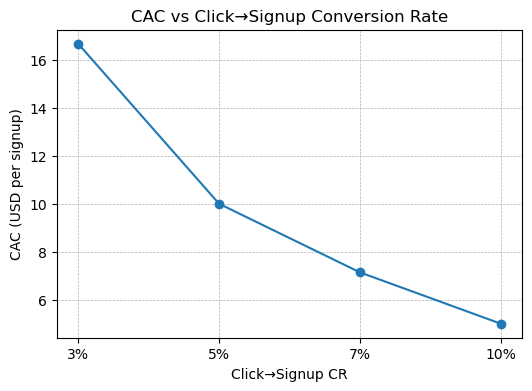

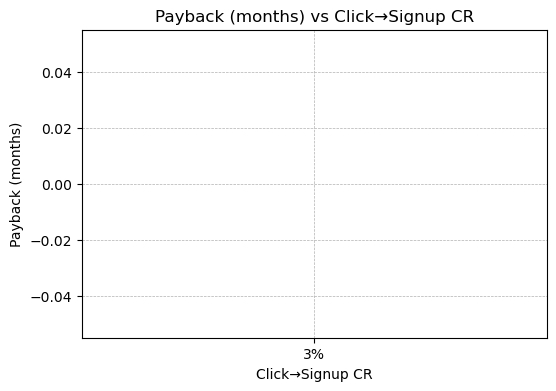

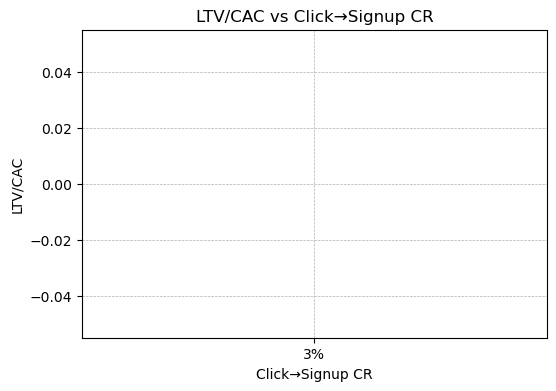

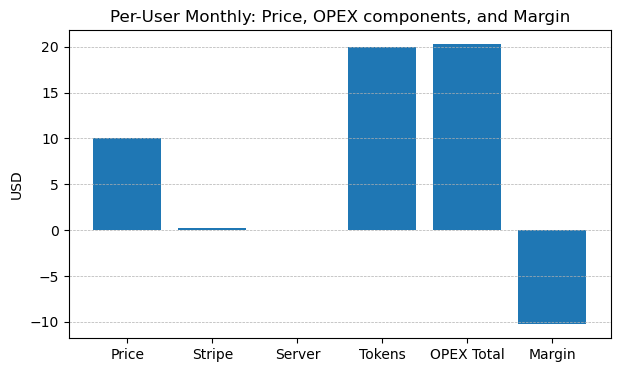

In [37]:
# ---------- Charts ----------
# A) CAC vs CR
plt.figure(figsize=(6,4))
plt.plot(results_df["CR_label"], results_df["CAC"], marker="o")
plt.title("CAC vs Click→Signup Conversion Rate")
plt.xlabel("Click→Signup CR")
plt.ylabel("CAC (USD per signup)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# B) Payback vs CR (∞ shown as NaN)
y_payback = results_df["Payback_Months"].replace(math.inf, np.nan)
plt.figure(figsize=(6,4))
plt.plot(results_df["CR_label"], y_payback, marker="o")
plt.title("Payback (months) vs Click→Signup CR")
plt.xlabel("Click→Signup CR")
plt.ylabel("Payback (months)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# C) LTV/CAC vs CR
ltv_over_cac = results_df["LTV_over_CAC"].astype(float)
plt.figure(figsize=(6,4))
plt.plot(results_df["CR_label"], ltv_over_cac, marker="o")
plt.title("LTV/CAC vs Click→Signup CR")
plt.xlabel("Click→Signup CR")
plt.ylabel("LTV/CAC")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# D) OPEX components and Margin (bars)
components = {
    "Price": price_usd,
    "Stripe": stripe_usd,
    "Server": server_cost_per_user,
    "Tokens": tokens_cost_per_user,
    "OPEX Total": opex_usd,
    "Margin": margin_usd
}
plt.figure(figsize=(7,4))
plt.bar(list(components.keys()), list(components.values()))
plt.title("Per-User Monthly: Price, OPEX components, and Margin")
plt.ylabel("USD")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.show()
